This tutorial shows the complete pipeline for the analysis of sparse VLBI data with the ring-image observed with EHT2017 coverage. Many cells are explained in previous tutorials.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)


Welcome to eht-imaging! v 1.2.6 



In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 128                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 8*10**9]       #cbar-lims for interactive plotting (brightness temperature)

Prepare data set, see tutorial 3

Loading uvfits:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring.fits


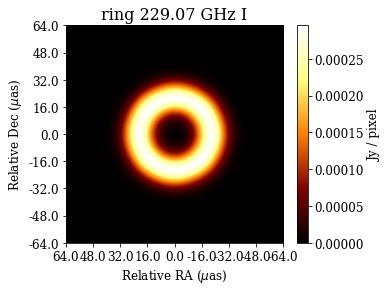

In [3]:
#-------------------------------------------------------------------------------
# Observe synthetic image and reduce/precalibrate synthetic observation
#-------------------------------------------------------------------------------

obs = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2017.uvfits')

#calibration object
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
#prepare (coherently average) data
cal.prepare_data()
#precalibrate data
cal.precalibrate_data()

obs_sc = cal.obs_sc #precalibrated and reduced data set

exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [4]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

This time we fit the widths of the wavelets to the array. Moreover, we add wavelet filters with the size of 1 pixels, 2 pixels and 4 pixels to complete the dictionary down to the pixel scale. However, these scales will be suppressed during imaging procedure.

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.15*10**9
#add short baselines wavelets 
short_bl_wl=[39.98, 47.24]
#add long baseline wavelets
long_bl_wl=[1, 2, 4]
#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


Instead of the dirty map, we are using an unpenalized ehtim reconstruction here to define an initial guess. The reconstruction is done with alternative blurring with the resolution of the observation to help global convergence in five cycles. The ehtim reconstruction is done internally by MrBeam by the command handler.first_round. Moreover, after each imaging round self-calibration could be done. Everytime the observation file is updated externally, the handler should be updated with the new observation file, i.e. the wrapper and functionals to the amplitude, phase, closure phase and closure amplitude are updated.

Round 1: Unconstrained Imaging with visibility amplitudes and closure quantities ...
Initializing imager data products . . .
U-V flagged 16/168 visibilities
U-V flagged 152/168 visibilities
Imager run 1 
Imaging . . .
time: 3.159341 s
J: 34.755579
chi2_amp : 69.97 chi2_cphase : 9.73 chi2_logcamp : 13.17 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 2.964140 s
J: 4.702812
chi2_amp : 15.61 chi2_cphase : 2.13 chi2_logcamp : 1.65 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 2.877504 s
J: -0.053444
chi2_amp : 2.70 chi2_cphase : 1.03 chi2_logcamp : 0.57 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 3.014473 s
J: -0.553979
chi2_amp : 1.70 chi2_cphase : 0.83 chi2_logcamp : 0.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 0.431273 s
J: -0.554181
chi2_amp : 1.70 chi2_cphase : 0.83 chi2_logcamp : 0.47 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 6 


time: 2.486786 s
J: -0.729638
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 38 
Imaging . . .
time: 0.249880 s
J: -0.729794
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 39 
Imaging . . .
time: 0.394176 s
J: -0.729911
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 40 
Imaging . . .
time: 0.282221 s
J: -0.730042
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 41 
Imaging . . .
time: 0.233961 s
J: -0.730183
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 42 
Imaging . . .
time: 0.387169 s
J: -0.730286
chi2_amp : 1.39 chi2_cphase : 0.75 chi2_logcamp : 0.44 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Imager run 43 
Imaging . . .
time: 0.290360 s
J: -0

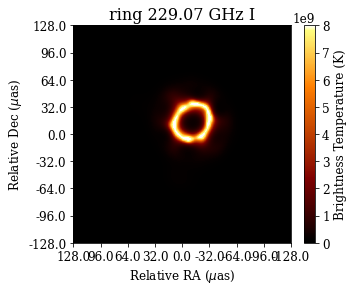

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 18/19 : [----------------------------  ]94%
self_cal time: 5.411608 s


In [6]:
#------------------------------------------------------------------------------
# First round of imaging: Unconstrained ehtim reconstruction
# alternating imaging and blurring to help global convergence
#------------------------------------------------------------------------------
print("Round 1: Unconstrained Imaging with visibility amplitudes and closure quantities ...")

#run minimization
img = handler.first_round(prior, data_term, cycles=5)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase-calibration
obs_sc = eh.selfcal(obs_sc, img, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Now we are computing the DoG-HiT minimization as in tutorial 5. The narrative here is somehow different than before. In previous examples we started from a clean image and looked for an image compatible with data. This time, the initial guess fits the data already very well, but is over-resolving and has image artifacts. DoG-HiT adds regularization while simultaneously keeping the quality of the fit (data fidelity term) and contrast in the image (total flux constraint). 

Round 2: Multiscalar Imaging with closure quantities ...
We use  7 scales with threshold 4.0
Current minimum 13.211480935593938
Start optimization with thresholds [1.e+04 1.e+04 1.e+04 1.e+04 4.e+00 4.e+00 4.e+00 4.e+00 4.e+00 4.e+00
 4.e+00 4.e+00]
reverse mode: True
Updated at scale 4 to threshold 3.5 to minimum 13.21006852334633
Updated at scale 4 to threshold 4.5 to minimum 13.193166708348954
Updated at scale 4 to threshold 5.0 to minimum 13.163426548982128
Updated at scale 4 to threshold 5.5 to minimum 13.162171211550417
Updated at scale 4 to threshold 7.0 to minimum 13.157188390828159
Updated at scale 4 to threshold 9.0 to minimum 13.142488054087687
Updated at scale 4 to threshold 9.5 to minimum 13.131786237312804
Updated at scale 5 to threshold 3.5 to minimum 13.12708012501156
Updated at scale 5 to threshold 5.0 to minimum 13.119514486537488
Updated at scale 6 to threshold 3.5 to minimum 13.049072233481818
Updated at scale 7 to threshold 3.5 to minimum 13.039530429450258
Updated

2023-11-22 09:13:42,236 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:13:42,243 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:44,744 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:13:44,752 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:47,283 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:13:47,288 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:49,857 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:13:49,865 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:52,333 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:13:52,333 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:54,817 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:13:54,825 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:13:57,367 INFO CountIterations      :: iteration = 7 / 25
2023

3979.0681235118736
Data Fidelity:  4.032201604275091


2023-11-22 09:14:46,680 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:14:46,680 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:14:49,183 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:14:49,192 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:14:51,697 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:14:51,706 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:14:54,173 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:14:54,181 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:14:56,716 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:14:56,724 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:14:59,187 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:14:59,195 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:15:01,707 INFO CountIterations      :: iteration = 7 / 25
2023

5991.168755528701
Data Fidelity:  3.759071034538655


2023-11-22 09:15:50,929 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:15:50,929 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:15:53,424 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:15:53,432 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:15:55,981 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:15:55,988 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:15:58,540 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:15:58,548 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:16:01,017 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:16:01,025 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:16:03,613 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:16:03,613 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:16:06,191 INFO CountIterations      :: iteration = 7 / 25
2023

5993.82117046718
Data Fidelity:  3.5767592700228414


2023-11-22 09:16:55,217 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:16:55,225 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:16:57,701 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:16:57,709 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:17:00,292 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:17:00,300 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:17:02,768 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:17:02,776 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:17:05,272 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:17:05,280 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:17:07,795 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:17:07,803 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:17:10,288 INFO CountIterations      :: iteration = 7 / 25
2023

5995.999375379031
Data Fidelity:  3.4438068837450855


2023-11-22 09:17:59,225 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:17:59,233 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:01,673 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:18:01,681 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:04,147 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:18:04,155 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:06,651 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:18:06,659 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:09,141 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:18:09,148 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:11,571 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:18:11,579 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:18:14,014 INFO CountIterations      :: iteration = 7 / 25
2023

5997.770846222951
Data Fidelity:  3.3419233375425


2023-11-22 09:19:02,668 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:19:02,676 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:05,177 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:19:05,185 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:07,590 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:19:07,598 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:10,114 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:19:10,114 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:12,590 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:19:12,590 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:15,046 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:19:15,054 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:19:17,504 INFO CountIterations      :: iteration = 7 / 25
2023

5999.207987957549
Data Fidelity:  3.261088508111667


2023-11-22 09:20:06,368 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:20:06,376 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:08,891 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:20:08,899 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:11,381 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:20:11,381 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:13,902 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:20:13,902 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:16,387 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:20:16,389 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:18,938 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:20:18,938 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:20:21,379 INFO CountIterations      :: iteration = 7 / 25
2023

6000.374437600314
Data Fidelity:  3.195102631088141


2023-11-22 09:21:09,848 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:21:09,848 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:12,402 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:21:12,410 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:14,861 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:21:14,869 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:17,335 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:21:17,343 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:19,827 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:21:19,827 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:22,257 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:21:22,262 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:21:24,691 INFO CountIterations      :: iteration = 7 / 25
2023

6001.322705733158
Data Fidelity:  3.1398608363260356


2023-11-22 09:22:13,416 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:22:13,424 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:15,862 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:22:15,870 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:18,334 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:22:18,342 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:20,825 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:22:20,833 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:23,351 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:22:23,359 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:25,806 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:22:25,806 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:22:28,281 INFO CountIterations      :: iteration = 7 / 25
2023

6002.095051304913
Data Fidelity:  3.0925352542030544


2023-11-22 09:23:17,023 INFO CountIterations      :: iteration = 1 / 25
2023-11-22 09:23:17,031 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:19,507 INFO CountIterations      :: iteration = 2 / 25
2023-11-22 09:23:19,515 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:21,994 INFO CountIterations      :: iteration = 3 / 25
2023-11-22 09:23:21,994 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:24,285 INFO CountIterations      :: iteration = 4 / 25
2023-11-22 09:23:24,293 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:26,410 INFO CountIterations      :: iteration = 5 / 25
2023-11-22 09:23:26,418 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:28,583 INFO CountIterations      :: iteration = 6 / 25
2023-11-22 09:23:28,583 INFO Display              :: Penalty--> 8.732564892298022
2023-11-22 09:23:30,646 INFO CountIterations      :: iteration = 7 / 25
2023

6002.725152264212
Data Fidelity:  3.0511277606227427


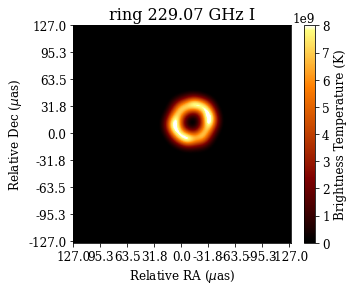

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 18/19 : [----------------------------  ]94%
self_cal time: 5.174436 s


In [7]:
#-------------------------
# Second Round of Imaging: closure-quantities + sparsity penalization + total flux constraint
#-------------------------

print("Round 2: Multiscalar Imaging with closure quantities ...")

alpha=0.5 #wavelet sparsity constraint
tau=10 #stepsize in minimization

#run mminimization
wtfcts, img = handler.second_round_minimization(img.copy(), alpha, tau, maxiter=10)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase-calibration
obs_sc = eh.selfcal(obs_sc, img, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Refinement with the multiresolution support as presented in tutorial 5.

Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...


2023-11-22 09:25:22,187 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:25:23,695 INFO Display              :: Data Fidelity--> 4.132865034889254
2023-11-22 09:25:27,247 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:25:28,755 INFO Display              :: Data Fidelity--> 4.11160365704458
2023-11-22 09:25:32,327 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:25:33,847 INFO Display              :: Data Fidelity--> 4.091884126607719
2023-11-22 09:25:37,325 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:25:38,805 INFO Display              :: Data Fidelity--> 4.0734443315846285
2023-11-22 09:25:42,337 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:25:42,337 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:25:42,345 INFO Gradient_Descent     :: Stopping rule triggered.
2023-11-22 09:25:47,833 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:25:49,345 INFO Display     

2023-11-22 09:29:29,846 INFO CountIterations      :: iteration = 30 / 100
2023-11-22 09:29:31,355 INFO Display              :: Data Fidelity--> 3.75689450223942
2023-11-22 09:29:34,912 INFO CountIterations      :: iteration = 31 / 100
2023-11-22 09:29:36,416 INFO Display              :: Data Fidelity--> 3.7472112688375505
2023-11-22 09:29:39,876 INFO CountIterations      :: iteration = 32 / 100
2023-11-22 09:29:41,381 INFO Display              :: Data Fidelity--> 3.7376169093859364
2023-11-22 09:29:44,840 INFO CountIterations      :: iteration = 33 / 100
2023-11-22 09:29:46,369 INFO Display              :: Data Fidelity--> 3.728107885150564
2023-11-22 09:29:49,880 INFO CountIterations      :: iteration = 34 / 100
2023-11-22 09:29:51,377 INFO Display              :: Data Fidelity--> 3.718680962781568
2023-11-22 09:29:54,897 INFO CountIterations      :: iteration = 35 / 100
2023-11-22 09:29:56,410 INFO Display              :: Data Fidelity--> 3.709333179537982
2023-11-22 09:29:59,898 INF

2023-11-22 09:31:46,474 INFO Display              :: Data Fidelity--> 3.3462549166023017
2023-11-22 09:31:47,788 INFO CountIterations      :: iteration = 81 / 100
2023-11-22 09:31:48,295 INFO Display              :: Data Fidelity--> 3.3391691088389743
2023-11-22 09:31:49,547 INFO CountIterations      :: iteration = 82 / 100
2023-11-22 09:31:50,092 INFO Display              :: Data Fidelity--> 3.332118257377431
2023-11-22 09:31:51,349 INFO CountIterations      :: iteration = 83 / 100
2023-11-22 09:31:51,919 INFO Display              :: Data Fidelity--> 3.325102035110282
2023-11-22 09:31:53,173 INFO CountIterations      :: iteration = 84 / 100
2023-11-22 09:31:53,746 INFO Display              :: Data Fidelity--> 3.318120122656966
2023-11-22 09:31:55,032 INFO CountIterations      :: iteration = 85 / 100
2023-11-22 09:31:55,575 INFO Display              :: Data Fidelity--> 3.31117220803885
2023-11-22 09:31:56,850 INFO CountIterations      :: iteration = 86 / 100
2023-11-22 09:31:57,384 INF

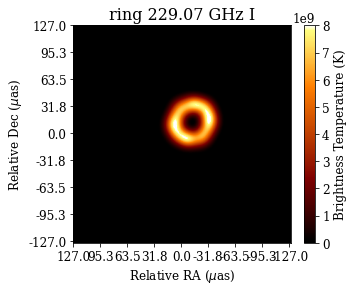

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 18/19 : [----------------------------  ]94%
self_cal time: 1.120057 s


In [8]:
#-------------------------
# Third Round of Imaging: amplitude+closure-quantities + multiresolution support constraint
#-------------------------

print("Third Round: Multiscalar Imaging with visibility amplitudes and closure quantities ...")

#run gradient descent minimization
#stepsize automatically found
wtfcts, img, tau = handler.third_round(wtfcts, data_term, tau=tau, maxit=100)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase-calibration
obs_sc = eh.selfcal(obs_sc, img, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Further refinement round with updated data term

Round 4: Multiscalar Imaging with visibilities and closure quantities ...


2023-11-22 09:32:50,206 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:32:50,592 INFO Display              :: Data Fidelity--> 4.464947593356115
2023-11-22 09:32:51,536 INFO CountIterations      :: iteration = 2 / 5
2023-11-22 09:32:51,935 INFO Display              :: Data Fidelity--> 4.445673026187288
2023-11-22 09:32:52,852 INFO CountIterations      :: iteration = 3 / 5
2023-11-22 09:32:53,274 INFO Display              :: Data Fidelity--> 4.426965162679674
2023-11-22 09:32:54,223 INFO CountIterations      :: iteration = 4 / 5
2023-11-22 09:32:54,608 INFO Display              :: Data Fidelity--> 4.4086982356832305
2023-11-22 09:32:55,538 INFO CountIterations      :: iteration = 5 / 5
2023-11-22 09:32:55,539 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-11-22 09:32:55,539 INFO Gradient_Descent     :: Stopping rule triggered.
2023-11-22 09:32:56,955 INFO CountIterations      :: iteration = 1 / 5
2023-11-22 09:32:57,346 INFO Display    

2023-11-22 09:34:15,352 INFO CountIterations      :: iteration = 30 / 100
2023-11-22 09:34:16,661 INFO Display              :: Data Fidelity--> 4.0148487629642515
2023-11-22 09:34:19,737 INFO CountIterations      :: iteration = 31 / 100
2023-11-22 09:34:21,093 INFO Display              :: Data Fidelity--> 4.001815474673491
2023-11-22 09:34:24,182 INFO CountIterations      :: iteration = 32 / 100
2023-11-22 09:34:25,522 INFO Display              :: Data Fidelity--> 3.9889041069544433
2023-11-22 09:34:28,598 INFO CountIterations      :: iteration = 33 / 100
2023-11-22 09:34:29,917 INFO Display              :: Data Fidelity--> 3.976112469333926
2023-11-22 09:34:32,976 INFO CountIterations      :: iteration = 34 / 100
2023-11-22 09:34:34,283 INFO Display              :: Data Fidelity--> 3.9634384577174346
2023-11-22 09:34:37,306 INFO CountIterations      :: iteration = 35 / 100
2023-11-22 09:34:38,606 INFO Display              :: Data Fidelity--> 3.9508800474421237
2023-11-22 09:34:41,667 

2023-11-22 09:37:57,846 INFO Display              :: Data Fidelity--> 3.4817015994254037
2023-11-22 09:37:59,134 INFO CountIterations      :: iteration = 81 / 100
2023-11-22 09:37:59,568 INFO Display              :: Data Fidelity--> 3.4730113941072402
2023-11-22 09:38:00,549 INFO CountIterations      :: iteration = 82 / 100
2023-11-22 09:38:00,945 INFO Display              :: Data Fidelity--> 3.464383332115866
2023-11-22 09:38:01,866 INFO CountIterations      :: iteration = 83 / 100
2023-11-22 09:38:02,252 INFO Display              :: Data Fidelity--> 3.4558167419634462
2023-11-22 09:38:03,165 INFO CountIterations      :: iteration = 84 / 100
2023-11-22 09:38:03,543 INFO Display              :: Data Fidelity--> 3.4473109633977197
2023-11-22 09:38:04,450 INFO CountIterations      :: iteration = 85 / 100
2023-11-22 09:38:04,841 INFO Display              :: Data Fidelity--> 3.4388653471402812
2023-11-22 09:38:05,802 INFO CountIterations      :: iteration = 86 / 100
2023-11-22 09:38:06,208

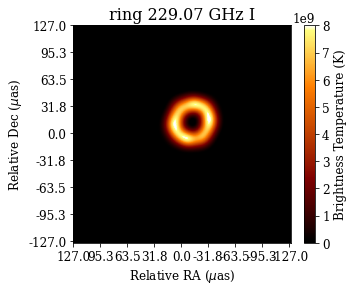

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 18/19 : [----------------------------  ]94%
self_cal time: 1.401137 s


In [9]:
#-------------------------
# Fourth Round of Imaging: visibilities+closure_quantities + multiresolution support contraint
#-------------------------

print("Round 4: Multiscalar Imaging with visibilities and closure quantities ...")

#data weights
data_term = {'vis'    : 1.0,    # visibilities
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

#run gradient descent minimization
#stepsize automatically found
coeff, img, tau = handler.fourth_round(wtfcts, data_term, tau=tau, maxit=100)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)

#phase+amplitude calibration
obs_sc = eh.selfcal(obs_sc, img, method='both', ttype=ttype)
handler.updateobs(obs_sc.copy())

Last refinement round with small stepsize gardient descent to self-calibrated dataset to increase fit to data. This last round doesn't change the image on a level visible by eye anymore.

2023-10-18 15:45:17,047 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:17,083 INFO Display              :: Data Fidelity--> 19.369443427363557


Round 5: Single Scalar Imaging with visibilities ...


2023-10-18 15:45:17,154 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:17,198 INFO Display              :: Data Fidelity--> 9555.735007838302
2023-10-18 15:45:17,260 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:17,294 INFO Display              :: Data Fidelity--> 2171764.77100131
2023-10-18 15:45:17,347 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:17,377 INFO Display              :: Data Fidelity--> 504537758.7552056
2023-10-18 15:45:17,441 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:17,443 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:17,444 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:17,541 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:17,568 INFO Display              :: Data Fidelity--> 5.916845185611192
2023-10-18 15:45:17,626 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:17,659 INFO Display      

Stepsize to big, try to run with smaller stepsize


2023-10-18 15:45:17,735 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:17,771 INFO Display              :: Data Fidelity--> 27174.990333495625
2023-10-18 15:45:17,831 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:17,867 INFO Display              :: Data Fidelity--> 1359769.485967847
2023-10-18 15:45:17,928 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:17,930 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:17,932 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:18,015 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:18,051 INFO Display              :: Data Fidelity--> 3.219663382914017
2023-10-18 15:45:18,109 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:18,142 INFO Display              :: Data Fidelity--> 45.682746327571635


Stepsize to big, try to run with smaller stepsize


2023-10-18 15:45:18,217 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:18,249 INFO Display              :: Data Fidelity--> 859.9106763966694
2023-10-18 15:45:18,307 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:18,341 INFO Display              :: Data Fidelity--> 8475.41896532089
2023-10-18 15:45:18,396 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:18,397 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:18,398 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:18,478 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:18,510 INFO Display              :: Data Fidelity--> 2.7079601140190497
2023-10-18 15:45:18,570 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:18,604 INFO Display              :: Data Fidelity--> 6.613151445423508


Stepsize to big, try to run with smaller stepsize


2023-10-18 15:45:18,679 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:18,719 INFO Display              :: Data Fidelity--> 46.3312807021306
2023-10-18 15:45:18,784 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:18,820 INFO Display              :: Data Fidelity--> 193.03771942978526
2023-10-18 15:45:18,888 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:18,890 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:18,892 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:18,979 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:19,005 INFO Display              :: Data Fidelity--> 2.6440717286226603
2023-10-18 15:45:19,068 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:19,101 INFO Display              :: Data Fidelity--> 2.8047930890981108


Stepsize to big, try to run with smaller stepsize


2023-10-18 15:45:19,176 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:19,209 INFO Display              :: Data Fidelity--> 3.417393209839708
2023-10-18 15:45:19,274 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:19,310 INFO Display              :: Data Fidelity--> 4.6226142997985065
2023-10-18 15:45:19,384 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:19,386 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:19,388 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:19,486 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:19,520 INFO Display              :: Data Fidelity--> 2.6697504504320246
2023-10-18 15:45:19,590 INFO CountIterations      :: iteration = 2 / 5


Stepsize to big, try to run with smaller stepsize


2023-10-18 15:45:19,638 INFO Display              :: Data Fidelity--> 2.6174241104989564
2023-10-18 15:45:19,696 INFO CountIterations      :: iteration = 3 / 5
2023-10-18 15:45:19,736 INFO Display              :: Data Fidelity--> 2.575818597142857
2023-10-18 15:45:19,800 INFO CountIterations      :: iteration = 4 / 5
2023-10-18 15:45:19,841 INFO Display              :: Data Fidelity--> 2.5431340474115953
2023-10-18 15:45:19,907 INFO CountIterations      :: iteration = 5 / 5
2023-10-18 15:45:19,908 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2023-10-18 15:45:19,909 INFO Gradient_Descent     :: Stopping rule triggered.
2023-10-18 15:45:20,008 INFO CountIterations      :: iteration = 1 / 5
2023-10-18 15:45:20,044 INFO Display              :: Data Fidelity--> 2.4958991844451273
2023-10-18 15:45:20,118 INFO CountIterations      :: iteration = 2 / 5
2023-10-18 15:45:20,157 INFO Display              :: Data Fidelity--> 2.4782417192021016
2023-10-18 15:45:20,

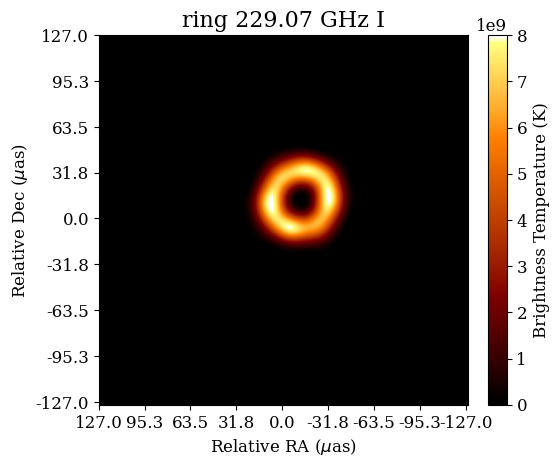

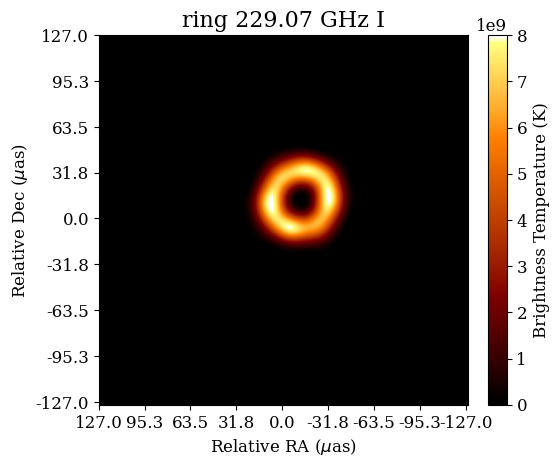

2022-08-05 11:33:42,700 INFO CountIterations      :: iteration = 432 / 1000
2022-08-05 11:33:42,724 INFO Display              :: Data Fidelity--> 1.6688981290437894
2022-08-05 11:33:42,771 INFO CountIterations      :: iteration = 433 / 1000
2022-08-05 11:33:42,795 INFO Display              :: Data Fidelity--> 1.65861391220673
2022-08-05 11:33:42,843 INFO CountIterations      :: iteration = 434 / 1000
2022-08-05 11:33:42,867 INFO Display              :: Data Fidelity--> 1.6680400179708483
2022-08-05 11:33:42,915 INFO CountIterations      :: iteration = 435 / 1000
2022-08-05 11:33:42,938 INFO Display              :: Data Fidelity--> 1.6577655874587593
2022-08-05 11:33:42,986 INFO CountIterations      :: iteration = 436 / 1000
2022-08-05 11:33:43,011 INFO Display              :: Data Fidelity--> 1.667188962980484
2022-08-05 11:33:43,060 INFO CountIterations      :: iteration = 437 / 1000
2022-08-05 11:33:43,084 INFO Display              :: Data Fidelity--> 1.6569243017872275
2022-08-05 11

2022-08-05 11:33:46,445 INFO CountIterations      :: iteration = 482 / 1000
2022-08-05 11:33:46,469 INFO Display              :: Data Fidelity--> 1.649425933076497
2022-08-05 11:33:46,517 INFO CountIterations      :: iteration = 483 / 1000
2022-08-05 11:33:46,540 INFO Display              :: Data Fidelity--> 1.6393804877191858
2022-08-05 11:33:46,587 INFO CountIterations      :: iteration = 484 / 1000
2022-08-05 11:33:46,611 INFO Display              :: Data Fidelity--> 1.6487266577847175
2022-08-05 11:33:46,659 INFO CountIterations      :: iteration = 485 / 1000
2022-08-05 11:33:46,683 INFO Display              :: Data Fidelity--> 1.638690478483859
2022-08-05 11:33:46,731 INFO CountIterations      :: iteration = 486 / 1000
2022-08-05 11:33:46,753 INFO Display              :: Data Fidelity--> 1.648033009768266
2022-08-05 11:33:46,800 INFO CountIterations      :: iteration = 487 / 1000
2022-08-05 11:33:46,824 INFO Display              :: Data Fidelity--> 1.638006072733726
2022-08-05 11:

2022-08-05 11:33:50,309 INFO CountIterations      :: iteration = 532 / 1000
2022-08-05 11:33:50,337 INFO Display              :: Data Fidelity--> 1.6335154429102525
2022-08-05 11:33:50,407 INFO CountIterations      :: iteration = 533 / 1000
2022-08-05 11:33:50,437 INFO Display              :: Data Fidelity--> 1.6236942612438106
2022-08-05 11:33:50,500 INFO CountIterations      :: iteration = 534 / 1000
2022-08-05 11:33:50,525 INFO Display              :: Data Fidelity--> 1.632941854726851
2022-08-05 11:33:50,595 INFO CountIterations      :: iteration = 535 / 1000
2022-08-05 11:33:50,622 INFO Display              :: Data Fidelity--> 1.6231293156787272
2022-08-05 11:33:50,668 INFO CountIterations      :: iteration = 536 / 1000
2022-08-05 11:33:50,691 INFO Display              :: Data Fidelity--> 1.6323726841829107
2022-08-05 11:33:50,757 INFO CountIterations      :: iteration = 537 / 1000
2022-08-05 11:33:50,787 INFO Display              :: Data Fidelity--> 1.6225687621960168
2022-08-05 

2022-08-05 11:33:54,105 INFO CountIterations      :: iteration = 582 / 1000
2022-08-05 11:33:54,129 INFO Display              :: Data Fidelity--> 1.6204053962666596
2022-08-05 11:33:54,177 INFO CountIterations      :: iteration = 583 / 1000
2022-08-05 11:33:54,202 INFO Display              :: Data Fidelity--> 1.6107926459142778
2022-08-05 11:33:54,251 INFO CountIterations      :: iteration = 584 / 1000
2022-08-05 11:33:54,275 INFO Display              :: Data Fidelity--> 1.6199300082595098
2022-08-05 11:33:54,326 INFO CountIterations      :: iteration = 585 / 1000
2022-08-05 11:33:54,349 INFO Display              :: Data Fidelity--> 1.610325267827508
2022-08-05 11:33:54,397 INFO CountIterations      :: iteration = 586 / 1000
2022-08-05 11:33:54,420 INFO Display              :: Data Fidelity--> 1.6194580562878071
2022-08-05 11:33:54,469 INFO CountIterations      :: iteration = 587 / 1000
2022-08-05 11:33:54,493 INFO Display              :: Data Fidelity--> 1.6098613010327933
2022-08-05 

2022-08-05 11:33:57,839 INFO CountIterations      :: iteration = 632 / 1000
2022-08-05 11:33:57,863 INFO Display              :: Data Fidelity--> 1.6094757233575696
2022-08-05 11:33:57,911 INFO CountIterations      :: iteration = 633 / 1000
2022-08-05 11:33:57,934 INFO Display              :: Data Fidelity--> 1.6000559602965143
2022-08-05 11:33:57,982 INFO CountIterations      :: iteration = 634 / 1000
2022-08-05 11:33:58,008 INFO Display              :: Data Fidelity--> 1.6090765563947986
2022-08-05 11:33:58,056 INFO CountIterations      :: iteration = 635 / 1000
2022-08-05 11:33:58,078 INFO Display              :: Data Fidelity--> 1.5996642065858733
2022-08-05 11:33:58,125 INFO CountIterations      :: iteration = 636 / 1000
2022-08-05 11:33:58,147 INFO Display              :: Data Fidelity--> 1.6086800523444351
2022-08-05 11:33:58,195 INFO CountIterations      :: iteration = 637 / 1000
2022-08-05 11:33:58,220 INFO Display              :: Data Fidelity--> 1.599275092980963
2022-08-05 

2022-08-05 11:34:01,549 INFO CountIterations      :: iteration = 682 / 1000
2022-08-05 11:34:01,571 INFO Display              :: Data Fidelity--> 1.6002366745509704
2022-08-05 11:34:01,617 INFO CountIterations      :: iteration = 683 / 1000
2022-08-05 11:34:01,638 INFO Display              :: Data Fidelity--> 1.5909956076486444
2022-08-05 11:34:01,684 INFO CountIterations      :: iteration = 684 / 1000
2022-08-05 11:34:01,706 INFO Display              :: Data Fidelity--> 1.5998965864126646
2022-08-05 11:34:01,752 INFO CountIterations      :: iteration = 685 / 1000
2022-08-05 11:34:01,774 INFO Display              :: Data Fidelity--> 1.590662389717378
2022-08-05 11:34:01,825 INFO CountIterations      :: iteration = 686 / 1000
2022-08-05 11:34:01,935 INFO Display              :: Data Fidelity--> 1.599558564173742
2022-08-05 11:34:01,984 INFO CountIterations      :: iteration = 687 / 1000
2022-08-05 11:34:02,009 INFO Display              :: Data Fidelity--> 1.5903312171555921
2022-08-05 1

2022-08-05 11:34:05,734 INFO CountIterations      :: iteration = 732 / 1000
2022-08-05 11:34:05,759 INFO Display              :: Data Fidelity--> 1.5923093212958168
2022-08-05 11:34:05,807 INFO CountIterations      :: iteration = 733 / 1000
2022-08-05 11:34:05,830 INFO Display              :: Data Fidelity--> 1.583234059710292
2022-08-05 11:34:05,879 INFO CountIterations      :: iteration = 734 / 1000
2022-08-05 11:34:05,902 INFO Display              :: Data Fidelity--> 1.5920151551368606
2022-08-05 11:34:05,952 INFO CountIterations      :: iteration = 735 / 1000
2022-08-05 11:34:05,977 INFO Display              :: Data Fidelity--> 1.5829462776470233
2022-08-05 11:34:06,027 INFO CountIterations      :: iteration = 736 / 1000
2022-08-05 11:34:06,052 INFO Display              :: Data Fidelity--> 1.591722599424765
2022-08-05 11:34:06,102 INFO CountIterations      :: iteration = 737 / 1000
2022-08-05 11:34:06,126 INFO Display              :: Data Fidelity--> 1.5826600877358243
2022-08-05 1

2022-08-05 11:34:09,415 INFO CountIterations      :: iteration = 782 / 1000
2022-08-05 11:34:09,440 INFO Display              :: Data Fidelity--> 1.5854042194769227
2022-08-05 11:34:09,489 INFO CountIterations      :: iteration = 783 / 1000
2022-08-05 11:34:09,514 INFO Display              :: Data Fidelity--> 1.5764832645489797
2022-08-05 11:34:09,579 INFO CountIterations      :: iteration = 784 / 1000
2022-08-05 11:34:09,609 INFO Display              :: Data Fidelity--> 1.585145971993898
2022-08-05 11:34:09,671 INFO CountIterations      :: iteration = 785 / 1000
2022-08-05 11:34:09,694 INFO Display              :: Data Fidelity--> 1.5762309686772726
2022-08-05 11:34:09,740 INFO CountIterations      :: iteration = 786 / 1000
2022-08-05 11:34:09,766 INFO Display              :: Data Fidelity--> 1.584888989756263
2022-08-05 11:34:09,836 INFO CountIterations      :: iteration = 787 / 1000
2022-08-05 11:34:09,868 INFO Display              :: Data Fidelity--> 1.5759799217877541
2022-08-05 1

2022-08-05 11:34:13,137 INFO CountIterations      :: iteration = 832 / 1000
2022-08-05 11:34:13,160 INFO Display              :: Data Fidelity--> 1.5793018298799597
2022-08-05 11:34:13,206 INFO CountIterations      :: iteration = 833 / 1000
2022-08-05 11:34:13,248 INFO Display              :: Data Fidelity--> 1.5705249558968304
2022-08-05 11:34:13,320 INFO CountIterations      :: iteration = 834 / 1000
2022-08-05 11:34:13,349 INFO Display              :: Data Fidelity--> 1.579071929524892
2022-08-05 11:34:13,419 INFO CountIterations      :: iteration = 835 / 1000
2022-08-05 11:34:13,449 INFO Display              :: Data Fidelity--> 1.5703006224277727
2022-08-05 11:34:13,496 INFO CountIterations      :: iteration = 836 / 1000
2022-08-05 11:34:13,519 INFO Display              :: Data Fidelity--> 1.5788430333783543
2022-08-05 11:34:13,566 INFO CountIterations      :: iteration = 837 / 1000
2022-08-05 11:34:13,595 INFO Display              :: Data Fidelity--> 1.5700772786802644
2022-08-05 

2022-08-05 11:34:17,216 INFO CountIterations      :: iteration = 882 / 1000
2022-08-05 11:34:17,241 INFO Display              :: Data Fidelity--> 1.5738360845990582
2022-08-05 11:34:17,291 INFO CountIterations      :: iteration = 883 / 1000
2022-08-05 11:34:17,318 INFO Display              :: Data Fidelity--> 1.5651941826184377
2022-08-05 11:34:17,370 INFO CountIterations      :: iteration = 884 / 1000
2022-08-05 11:34:17,395 INFO Display              :: Data Fidelity--> 1.5736288047743572
2022-08-05 11:34:17,446 INFO CountIterations      :: iteration = 885 / 1000
2022-08-05 11:34:17,470 INFO Display              :: Data Fidelity--> 1.5649921262854132
2022-08-05 11:34:17,519 INFO CountIterations      :: iteration = 886 / 1000
2022-08-05 11:34:17,545 INFO Display              :: Data Fidelity--> 1.5734223315808231
2022-08-05 11:34:17,596 INFO CountIterations      :: iteration = 887 / 1000
2022-08-05 11:34:17,621 INFO Display              :: Data Fidelity--> 1.564790863619573
2022-08-05 

2022-08-05 11:34:21,709 INFO CountIterations      :: iteration = 932 / 1000
2022-08-05 11:34:21,733 INFO Display              :: Data Fidelity--> 1.5688812847152938
2022-08-05 11:34:21,782 INFO CountIterations      :: iteration = 933 / 1000
2022-08-05 11:34:21,807 INFO Display              :: Data Fidelity--> 1.5603662048916194
2022-08-05 11:34:21,854 INFO CountIterations      :: iteration = 934 / 1000
2022-08-05 11:34:21,879 INFO Display              :: Data Fidelity--> 1.5686922848874343
2022-08-05 11:34:21,944 INFO CountIterations      :: iteration = 935 / 1000
2022-08-05 11:34:21,968 INFO Display              :: Data Fidelity--> 1.5601821204136535
2022-08-05 11:34:22,039 INFO CountIterations      :: iteration = 936 / 1000
2022-08-05 11:34:22,069 INFO Display              :: Data Fidelity--> 1.5685039416217057
2022-08-05 11:34:22,117 INFO CountIterations      :: iteration = 937 / 1000
2022-08-05 11:34:22,141 INFO Display              :: Data Fidelity--> 1.5599986808264357
2022-08-05

2022-08-05 11:34:25,630 INFO CountIterations      :: iteration = 982 / 1000
2022-08-05 11:34:25,658 INFO Display              :: Data Fidelity--> 1.564341975934657
2022-08-05 11:34:25,713 INFO CountIterations      :: iteration = 983 / 1000
2022-08-05 11:34:25,743 INFO Display              :: Data Fidelity--> 1.5559463835747782
2022-08-05 11:34:25,790 INFO CountIterations      :: iteration = 984 / 1000
2022-08-05 11:34:25,814 INFO Display              :: Data Fidelity--> 1.5641679512991518
2022-08-05 11:34:25,862 INFO CountIterations      :: iteration = 985 / 1000
2022-08-05 11:34:25,886 INFO Display              :: Data Fidelity--> 1.5557769960207621
2022-08-05 11:34:25,933 INFO CountIterations      :: iteration = 986 / 1000
2022-08-05 11:34:25,957 INFO Display              :: Data Fidelity--> 1.563994468597636
2022-08-05 11:34:26,005 INFO CountIterations      :: iteration = 987 / 1000
2022-08-05 11:34:26,029 INFO Display              :: Data Fidelity--> 1.5556081398240507
2022-08-05 1

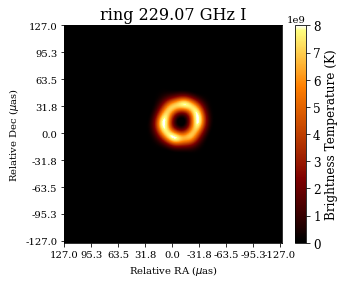

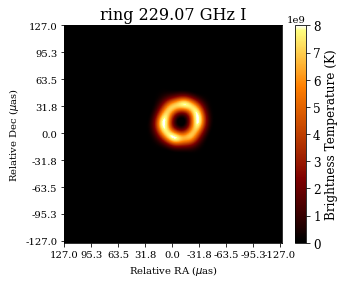

In [11]:
#-------------------------
# Fifth Round of Imaging: visibilities
#-------------------------

print("Round 5: Single Scalar Imaging with visibilities ...")

#project solution to postive values
init = np.maximum(0, img.imarr()/rescaling)

#run gradient descent minimization
#stepsize automatically found
img = handler.fifth_round(init.copy(), data_term, tau=tau, maxit=1000)

img.display(cbar_unit=['Tb'], cfun=cfun, cbar_lims=cbar_lims)